<a href="https://colab.research.google.com/github/kylemath/EEG-Classification/blob/master/notebooks/CNN_LSTM_Kyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN_LSTM_Kyle

Goal is to make a CNN LSTM stack that processes EEG trials as input and predicts binary category as output.


Strategy:
* Current code uses 25,000 examples of 100 long sentences in two categories, 
* Then is tested on 25000 sequences as well
* Instead try 250 by 100 data point long ERP for each trial 
* Predict target vs standard on any EEG dataset (start with Nathan skateboard data)
* Predict attend left vs attend right on muse 375 data

Using: 
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/pbashivan/EEGLearn
* https://github.com/tevisgehr/EEG-Classification

Resources:
*   http://proceedings.mlr.press/v56/Thodoroff16.pdf
*   https://arxiv.org/abs/1511.06448




In [1]:
!git clone https://github.com/tevisgehr/EEG-Classification.git
%cd EEG-Classification

Cloning into 'EEG-Classification'...
remote: Enumerating objects: 201, done.
remote: Total 201 (delta 0), reused 0 (delta 0), pack-reused 201
Receiving objects: 100% (201/201), 13.62 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/EEG-Classification


In [0]:
from eeg_learn_functions import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [0]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [0]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [0]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [0]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [0]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [0]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [0]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [60]:
file_names = ['data/ML102_KS.csv',
              'data/ML102_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML102_KS.csv . ( 1  of  2 )
222  frames generated with label  1 .


Processing session:  data/ML102_US.csv . ( 2  of  2 )
218  frames generated with label  0 .




In [30]:
X.shape

(458, 28, 28, 3)

In [32]:
y.shape


(458,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


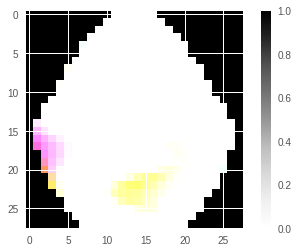

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[10]);
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


''

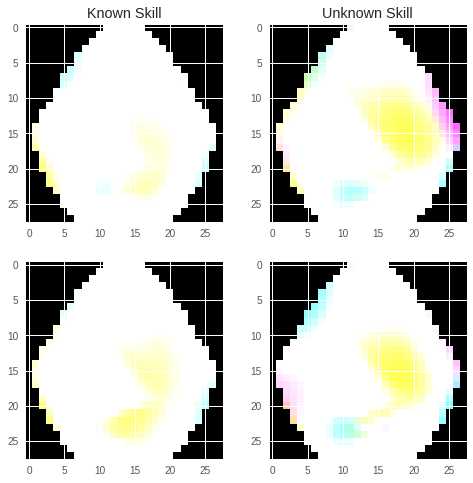

In [34]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Known Skill')
axarr[0][0].imshow(X[0])
axarr[1][0].imshow(X[1])

axarr[0][1].set_title('Unknown Skill')
axarr[0][1].imshow(X[20])
axarr[1][1].imshow(X[21])

;

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.20,shuffle=True)

In [62]:
print(y_train_temp.shape)
print(x_train.shape)
print(y_test_temp.shape)
print(x_test.shape)

(352,)
(352, 28, 28, 3)
(88,)
(88, 28, 28, 3)


In [63]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)



x_train shape: (352, 28, 28, 3)
352 train samples
88 test samples


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM, ConvLSTM2D

batch_size = 128
num_classes = 2
epochs = 400
lstm_output_size = 10


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_temp, num_classes)
y_test = keras.utils.to_categorical(y_test_temp, num_classes)


model = Sequential()
#model.add(ConvLSTM2D(lstm_output_size,input_shape=input_shape,kernel_size=3))
#model.add(Dense(num_classes))
#model.add(Activation('softmax'))


model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [65]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 352 samples, validate on 88 samples
Epoch 1/400
352/352 [==============================] - 1s 2ms/step - loss: 0.7196 - acc: 0.4886 - val_loss: 0.6895 - val_acc: 0.5000
Epoch 2/400
352/352 [==============================] - 0s 152us/step - loss: 0.6847 - acc: 0.5284 - val_loss: 0.6868 - val_acc: 0.5114
Epoch 3/400
352/352 [==============================] - 0s 155us/step - loss: 0.6835 - acc: 0.5426 - val_loss: 0.6846 - val_acc: 0.5455
Epoch 4/400
352/352 [==============================] - 0s 154us/step - loss: 0.6776 - acc: 0.5483 - val_loss: 0.6858 - val_acc: 0.5455
Epoch 5/400
352/352 [==============================] - 0s 155us/step - loss: 0.6727 - acc: 0.5909 - val_loss: 0.6800 - val_acc: 0.6136
Epoch 6/400
352/352 [==============================] - 0s 139us/step - loss: 0.6646 - acc: 0.6392 - val_loss: 0.6772 - val_acc: 0.6023
Epoch 7/400
352/352 [==============================] - 0s 138us/step - loss: 0.6677 - acc: 0.5909 - val_loss: 0.6747 - val_acc: 0.5568
Epoch 8/400


In [0]:
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

729/729 [==============================] - 0s 51us/step
Test score: 0.5609426110860252
Test accuracy: 0.7338820317318083
